In [8]:
"""Parsing code for DICOMS and contour files"""

import dicom
from dicom.errors import InvalidDicomError

import numpy as np
from PIL import Image, ImageDraw

### Provided Code

In [2]:
def parse_dicom_file(filename):
    """Parse the given DICOM filename

    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """

    try:
        # extract pixel array
        dcm = dicom.read_file(filename)
        dcm_image = dcm.pixel_array
        
        # linear transformation from disk to memory representation
        # do only if rescale and slope is not 0 else leave disk
        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0
        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        
        # store in dict
        #dcm_dict = {'pixel_data' : dcm_image}
        #return dcm_dict
        
        # CHANGE IN CODE
        # we are returning only pixel array 
        # we don't need to create a dict for that
        return dcm_image
        
    except InvalidDicomError:
        return None

    
def parse_contour_file(filename):
    """Parse the given contour filename, if file
    can't be read give IOError
    
    :param filename: filepath to the contourfile to parse
    :return: list of tuples holding x, y coordinates of the contour
    """

    coords_lst = []
    with open(filename, 'r') as infile:
        for line in infile:
            coords = line.strip().split()

            x_coord = float(coords[0])
            y_coord = float(coords[1])
            coords_lst.append((x_coord, y_coord))
    return coords_lst

def poly_to_mask(polygon, width, height):
    """Convert polygon to mask

    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    #c
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask

**Part 1: Parse the DICOM images and Contour Files**

**How did you verify ...**

By Visualizing.

**What changes did you make to the code, ...**

I didn't change much rather built my code around it. I only change return of `parse_dicom_file` be np.array.


### NOTES

**Invalid Files**

There are dot files in the directories seems to be invalid while reading. Ignore dot files.

**Matching Problem : Image - Contour**

Assuming `IM-0001-0208` refers to slice 208 in `/...208.dcm`. But often it's better to get instances by looking at metadata provided in contour files. They will have InstanceID which will indicated the correct dicom image ID to match that particular contour. I would change this aspect of the pipeline, this might cause problems during matching if filenames are corrupted.

`'final_data/contourfiles/SC-HF-I-1/i-contours/._IM-0001-0208-icontour-manual.txt'`

**Code Check**

Visualization 

/images
        
    /i_contour
        
        /patient_dicom_id
        
            /slice_xx.png
   
    /o_contour
        
        /patient_dicom_id
        
            /slice_xx.png

In [5]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
final_data = list(Path('../final_data/').iterdir())
final_data

[PosixPath('../final_data/dicoms'),
 PosixPath('../final_data/images'),
 PosixPath('../final_data/contourfiles'),
 PosixPath('../final_data/link.csv')]

In [5]:
# pathlib objects
dicoms_path = final_data[0]
contourfiles_path = final_data[2]
link = pd.read_csv(final_data[3])

In [6]:
# rename dataframe columns for explicity
link = link.rename(columns={'patient_id':'dicoms', 'original_id':'contourfiles'})

# create link pairs of dicom_id anf contourfiles_id
link_pairs = list(zip(link['dicoms'], link['contourfiles']))

In [7]:
def get_patient_ids(link_pairs, i):
    """
    Get i th patient dicom and contour ids
    link_pairs (list): list of tuples that have patient_id and original_id
    """
    patient_dicom_id, patient_contour_id = link_pairs[i][0], link_pairs[i][1]
    return patient_dicom_id, patient_contour_id

In [8]:
def get_patient_files(patient_dicom_id, patient_contour_id,
                      dicoms_path, contourfiles_path, verbose=True):
    """
    Get all dicom, i_contour and o_contour filenames of a given paient.
    Inputs:
        patient_dicom_id (pathlib.PosixPath): directory name for dicom files
        patient_contour_id (pathlib.PosixPath): directory name for contours
        dicoms_path (pathlib.PosixPath): main directory path for dicoms
        contours_path (pathlib.PosixPath): main directory path for contours
    Return:
        dicoms_valid (list): list of dicom image file paths
        i_contours_valid (list): list of i_contours file paths
        o_contours_valid (list): list of o_contours file paths
    """
    # extract all pathlib objects in directories
    dicoms = list((dicoms_path/patient_dicom_id).iterdir())
    i_contours = list((contourfiles_path/patient_contour_id/'i-contours').iterdir())
    o_contours = list((contourfiles_path/patient_contour_id/'o-contours').iterdir())
    
    # extract non-dot files as valid files
    dicoms_valid = [str(o) for o in dicoms if o.name[0] != '.']
    i_contours_valid = [str(o) for o in i_contours if o.name[0] != '.']
    o_contours_valid = [str(o) for o in o_contours if o.name[0] != '.']
    
    if verbose:
        
        print(f"# of dicoms : {len(dicoms)}, i_contours : \
{len(i_contours)}, o_contours : {len(o_contours)}")

        print(f"# of valid dicoms : {len(dicoms_valid)}, \
        i_contours : {len(i_contours_valid)}, \
o_contours : {len(o_contours_valid)}")
    
    return (dicoms_valid, i_contours_valid, o_contours_valid)

In [9]:
# sample patient i
i = 2
patient_dicom_id, patient_contour_id = get_patient_ids(link_pairs, i)

In [10]:
# extract filennames for the given patient
dicoms, i_contours, o_contours = get_patient_files(patient_dicom_id, patient_contour_id,
                                                  dicoms_path, contourfiles_path)

# of dicoms : 400, i_contours : 40, o_contours : 20
# of valid dicoms : 200, i_contours : 20, o_contours : 10


In [11]:
def dicom_slice_dict(dicoms):
    """
    creates a slice dict in order
    Input:
        dicoms (list): valid dicom files of a patient
    Return:
        dicoms_dict (dict): ordered dict by slice order
    """
    dicoms_dict = {}
    for dicom_fn in dicoms:
        slice_no = int(dicom_fn.split('/')[-1].split('.')[0])
        dicoms_dict[slice_no] = dicom_fn
    return dicoms_dict

In [12]:
def contour_slice_dict(contours):
    """
    creates a slice dict in order for contour files
    Input:
        contours (list): valid contour files of a patient
    Return:
        contours_dict (dict): ordered dict by slice order
    """
    contours_dict = {}
    for contour_fn in contours:
        slice_no = int(contour_fn.split('/')[-1].split('-')[2])
        contours_dict[slice_no] = contour_fn
    return contours_dict

In [13]:
dicoms_dict = dicom_slice_dict(dicoms)
i_contours_dict = contour_slice_dict(i_contours)
o_contours_dict = contour_slice_dict(o_contours)

In [14]:
def patient_files_dict(dicoms_dict, i_contours_dict, o_contours_dict):
    """
    Create an ordered dictionary containing list of
    dicom filepath, i_contour path, o_contour_path
    
    Inputs:
        dicoms_dict (dict): ordered dict of dicom files
        i_contours_dict (dict): ordered dict of i_contour files
        o_contours_dict (dict): ordered dict of o_contour files
    
    Return:
        patient_files_dict (dict): ordered dict with same size as 
        original dicom images containing 
        
        list for [dicom file path, i_contour file path, o_contour file path]
    """
    patient_files_dict = {}
    for slice_no in dicoms_dict:
        dicom_fname = dicoms_dict.get(slice_no)
        i_contour_fname = i_contours_dict.get(slice_no)
        o_contour_fname = o_contours_dict.get(slice_no)
        
        patient_files_dict[slice_no] = {'dicom_fname': dicom_fname, 
                                        'i_contour_fname': i_contour_fname,
                                        'o_contour_fname': o_contour_fname}
    return patient_files_dict

In [15]:
# storing this better for memory issues 
# we can use these paths for Dataloader
all_files_dict = patient_files_dict(dicoms_dict, i_contours_dict, o_contours_dict)

### Plot for sanity check

The best way of verifying your data and target in object detection or segmentation tasks is to actually visually inspect them. That's what top CV engineers including all Kaggle Grandmasters recommend. Of course, if there is a mistake made in metadata and if we suspect that some contours are very off even though some of them are correct, it's better to show it to a medical expert for verification. E.g, when I was working with tumor segmentation data some of the tumors on the same slice were left unlabeled. Code was working and it turned out that only the tumors that would be treated were labeled in this dataset. This kind of situations affects our ground-truth and confuses the models, so they should be taken care of with caution. 

In [16]:
def show_img_msk_fromarray(img_arr, msk_arr, alpha=0.35, sz=7, cmap='inferno', save_path=None):

    """
    Show original image and masked on top of image
    next to each other in desired size
    Input:
        img_arr (np.array): array of the image
        msk_arr (np.array): array of the mask
        alpha (float): a number between 0 and 1 for mask transparency
        sz (int): figure size for display
        save_path (str): path to save the figure
    """

    msk_arr = np.ma.masked_where(msk_arr == 0, msk_arr)
    plt.figure(figsize=(sz, sz))
    plt.subplot(1, 2, 1)
    plt.imshow(img_arr)
    plt.imshow(msk_arr, cmap=cmap, alpha=alpha)
    plt.subplot(1, 2, 2)
    plt.imshow(img_arr)
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()

### Part 1 Full Pipeline

1) Get patient id s for a given patient from the csv file

2) Extract filenames for the same patient - dicoms, i_contours, o_contours

3) Create ordered dict for dicoms and contours: as `{order : filename}`

4) Collect all order matching files: as `{order: [dicom, i_contour, o_contour]}` 


**Note: I like to keep things at patient level rather than joinining all patient files together since files of each patient are dependent and in future (for 3D applications) Dataloader will need this information**

In [17]:
class Patient:
    def __init__(self, dicom_id, contour_id, dicoms_path, contourfiles_path):
        """
        dicom_id (str): directory name under "dicoms/" 
        contour_id (str): directory name under "contourfiles/"
        dicoms_path (pathlib.PosixPath): pathlib object for dicoms parent dir
        contourfiles_path (pathlib.PosixPath): pathlib object for contourfiles parent dir
        """
        
        self.dicom_id = dicom_id
        self.contour_id = contour_id
        self.dicoms_path = dicoms_path
        self.contourfiles_path = contourfiles_path
        
    def create_file_lists(self, verbose=True):
        """
        Creates lists for dicom, i_contour and o_contour files
        """
        self.dicoms, self.i_contours, self.o_contours = get_patient_files(self.dicom_id, self.contour_id,
                                                  self.dicoms_path, self.contourfiles_path, verbose)
    
    def create_file_dicts(self, verbose=True):
        """
        Creates ordered dicts for dicoms, i_contours, o_contours filenames and all files combined
        """
        if not hasattr(self, 'dicoms'):
            self.create_file_lists(verbose)
        
        #pdb.set_trace()
        
        self.dicoms_dict = dicom_slice_dict(self.dicoms)
        self.i_contours_dict = contour_slice_dict(self.i_contours)
        self.o_contours_dict = contour_slice_dict(self.o_contours)
        self.all_files_dict = patient_files_dict(self.dicoms_dict, self.i_contours_dict, self.o_contours_dict)
    
    def create_numpy_arrays(self, verbose=True):
        """
        Creates ordered dict of dicts having np.array for dicom, i_contour and o_contour
        """
        if not hasattr(self, 'all_files_dict'):
            self.create_file_dicts(verbose)
            
        self.all_numpy_dict = {}
        for slice_no in self.all_files_dict:
            
            dicom_fn =  self.all_files_dict[slice_no]['dicom_fname']
            i_contour_fn = self.all_files_dict[slice_no]['i_contour_fname']
            o_contour_fn = self.all_files_dict[slice_no]['o_contour_fname']

            # parse dicom
            if dicom_fn is not None:
                img_array = parse_dicom_file(dicom_fn)
            else: img_array = None

            if img_array is not None:
                # get image size
                H, W = img_array.shape

                # parse i_contour
                if i_contour_fn is not None: 
                    i_contour_array = poly_to_mask(parse_contour_file(i_contour_fn)
                                                   , W, H).astype(np.uint8)
                else: i_contour_array = None

                # parse o_contour
                if o_contour_fn is not None: 
                    o_contour_array = poly_to_mask(parse_contour_file(o_contour_fn)
                                                   , W, H).astype(np.uint8)
                else: o_contour_array = None
            else: img_array, i_contour_array, o_contour_array = None, None, None
        
            self.all_numpy_dict[slice_no] = {'dicom_array': img_array, 
                                        'i_contour_array': i_contour_array,
                                        'o_contour_array': o_contour_array}
            

In [18]:
dicoms_path, contourfiles_path

(PosixPath('final_data/dicoms'), PosixPath('final_data/contourfiles'))

In [19]:
# sample i th patient
i = 0
patient_dicom_id, patient_contour_id = get_patient_ids(link_pairs, i)

In [20]:
patient_dicom_id, patient_contour_id

('SCD0000101', 'SC-HF-I-1')

In [21]:
# init patient
patient0 = Patient(patient_dicom_id, patient_contour_id, dicoms_path, contourfiles_path)

In [22]:
# let's create all numpy arrays
patient0.create_numpy_arrays()

# of dicoms : 480, i_contours : 36, o_contours : 18
# of valid dicoms : 240, i_contours : 18, o_contours : 9


In [23]:
numpy_dict = patient0.all_numpy_dict

### Create i_contour images

1) Let's go ahead an initialize every patient

2) Create a folder by their name

3) Save all i_contour-images under that folder

In [735]:
# create the images folder
#os.makedirs('final_data/images/', exist_ok=False)
#os.makedirs('final_data/images/i_contour/', exist_ok=False)
#os.makedirs('final_data/images/o_contour/', exist_ok=False)

In [24]:
link_pairs

[('SCD0000101', 'SC-HF-I-1'),
 ('SCD0000201', 'SC-HF-I-2'),
 ('SCD0000301', 'SC-HF-I-4'),
 ('SCD0000401', 'SC-HF-I-5'),
 ('SCD0000501', 'SC-HF-I-6')]

In [737]:
# initialize all patients
all_patients = []

for patient_dicom_id, patient_contour_id in link_pairs:
    patient = Patient(patient_dicom_id, patient_contour_id, dicoms_path, contourfiles_path)
    all_patients.append(patient)

In [4]:
def save_images(all_patients, contour_type = 'i_contour', main_dir='final_data/images/'):
    """
    Save dicom images and images with masks on top of the corresponding images.
    All files will will be saved under main dir by creating a new folder
    for contour type and then by creating a folder for each patient separately
    
    all_patients (list): list of Patient objects
    contour_type (str): either "i_contour" or "o_contour"
    """
    for patient in all_patients:
        print(patient.dicom_id)
        # create patient images folder
        dirname = main_dir + f'{contour_type}/{patient.dicom_id}/'
        os.makedirs(dirname, exist_ok=True)

        # create numpy arrays for the patient
        patient.create_numpy_arrays()
        
        # loop over slices in numpy array dict
        for slice_no in patient.all_numpy_dict:
            slice_dict = patient.all_numpy_dict[slice_no]

            # only show image for given contour type
            if slice_dict[f'{contour_type}_array'] is not None:
                img_array, msk_array = slice_dict['dicom_array'], slice_dict[f'{contour_type}_array']
                show_img_msk_fromarray(img_array, msk_array, cmap='Wistia', sz=10, alpha=0.7,
                                       save_path= dirname + f'slice_{slice_no}.png')

In [740]:
# save for i_contour
save_images(all_patients)

SCD0000101
SCD0000201
SCD0000301
SCD0000401
SCD0000501


In [741]:
# save for o_contour
save_images(all_patients, contour_type='o_contour')

SCD0000101
SCD0000201
SCD0000301
SCD0000401
SCD0000501


In [754]:
i = 0
for k in all_patients[4].all_files_dict:
    if all_patients[4].all_files_dict[k]['i_contour_fname'] is not None:
        i += 1

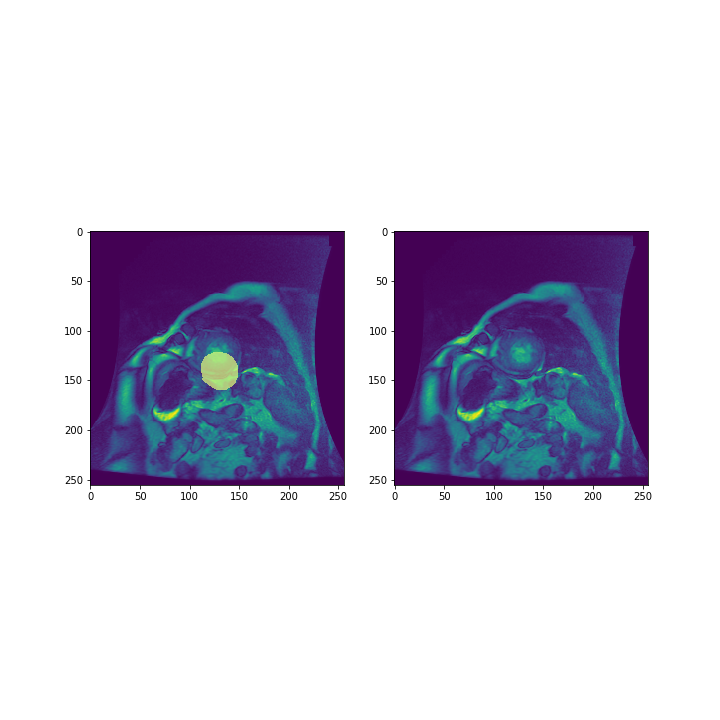

In [763]:
# There seems to be a shift in mask for SCD0000501 in o_contour
Image.open('../final_data/images/o_contour/SCD0000501/slice_199.png')

### Part 2 Dataset and Dataloader for 2D - PyTorch

In [25]:
# initialize all patients
all_patients = []

for patient_dicom_id, patient_contour_id in link_pairs:
    patient = Patient(patient_dicom_id, patient_contour_id, dicoms_path, contourfiles_path)
    all_patients.append(patient)

In [26]:
# create file dicts for each patient
for patient in all_patients:
    patient.create_file_dicts()

# of dicoms : 480, i_contours : 36, o_contours : 18
# of valid dicoms : 240, i_contours : 18, o_contours : 9
# of dicoms : 520, i_contours : 36, o_contours : 18
# of valid dicoms : 260, i_contours : 18, o_contours : 9
# of dicoms : 400, i_contours : 40, o_contours : 20
# of valid dicoms : 200, i_contours : 20, o_contours : 10
# of dicoms : 440, i_contours : 36, o_contours : 18
# of valid dicoms : 220, i_contours : 18, o_contours : 9
# of dicoms : 440, i_contours : 44, o_contours : 18
# of valid dicoms : 220, i_contours : 22, o_contours : 9


In [64]:
# dicom_contour_fnames = []

# patient = all_patients[0]
# for patient in all_patients:
#     for slice_no in patient.all_files_dict:
#         slice_dict = patient.all_files_dict[slice_no]
#         dicom_fname = slice_dict['dicom_fname']
#         i_contour_fname = slice_dict['i_contour_fname']
#         o_contour_fname = slice_dict['o_contour_fname']
#         if i_contour_fname is not None:
#             dicom_contour_fnames.append((dicom_fname, i_contour_fname))

In [106]:
from torch.utils.data import *
from torch import FloatTensor as FT

In [135]:
class HeartDataset2D(Dataset):
    """
    all_patients (list): list containing Patient objects
    contour_type (str): either 'i_contour' or 'o_contour'
    """
    def __init__(self, all_patients, contour_type):
        
        self.all_patients = all_patients
        self.contour_type = contour_type
        #self.model_type = model_type
        
        # get filenames
        self.dicom_contour_fnames = []
        for patient in self.all_patients:
            # create all files dict
            patient.create_file_dicts(False)
            # loop over slices
            for slice_no in patient.all_files_dict:
                slice_dict = patient.all_files_dict[slice_no]
                dicom_fname = slice_dict['dicom_fname']
                contour_fname = slice_dict[f'{self.contour_type}_fname']
                if contour_fname is not None:
                    self.dicom_contour_fnames.append((dicom_fname, contour_fname))

    def __getitem__(self, idx):
        # get filename pair by idx
        dicom_contour_fname = self.dicom_contour_fnames[idx]
        dicom_fname, contour_fname = dicom_contour_fname[0], dicom_contour_fname[1]        
        
        #
        img = parse_dicom_file(dicom_fname)
        H, W = img.shape
        msk = poly_to_mask(parse_contour_file(contour_fname), W, H).astype(np.uint8)
        
        return FT(img)[None, :], FT(msk)[None, :] # convert to FloatTensor and add channel (1)
        
    def __len__(self):
        return len(self.dicom_contour_fnames)

In [138]:
heart_ds = HeartDataset2D(all_patients, 'i_contour')

In [139]:
heart_dl = DataLoader(heart_ds, batch_size=8, shuffle=True)

In [140]:
X,Y =  next(iter(hearth_dl))

In [141]:
X.size(), Y.size()

(torch.Size([8, 1, 256, 256]), torch.Size([8, 1, 256, 256]))